# Magnetometer

The magnetic field sensor in the rocket is sensitive, but because the Earth's field is so weak it's easily overwhelmed by local effects (metal screws, magnetic fields from nearby wires, etc.). In order to get good orientation data we need to undo these local effects.

Before the flight we moved the rocket around in every direction to recored the magnetic field offset in each direction.

## Field Strength

First check, let's average the magnitude of the field and compare to what NOAA says it should have been for our location.

From [NOAA's magnetic field calculator](https://www.ngdc.noaa.gov/geomag/magfield.shtml)


 - Model Used: `WMM2015`
 - Latitude: `43.79613280° N`
 - Longitude: `120.65175340° W`
 - Elevation: `1390.0 m Mean Sea Level`

| Date | Declination (+E/-W) | Inclination (+D/-U) | Horizontal Intensity | North Comp (+N/-S) | East Comp (+E/-W) | Vertical Comp (+D/-U) | Total Field |
| ---- | ------------------- | ------------------- | -------------------- | ------------------ | -------------------- | --------------------- | ----------- | 
| 2015-07-17   | 14.7990° | 66.5386° | 20,754.1 nT | 20,065.7 nT | 5,301.2 nT | 47,819.4 nT | 52,129.0 nT | 
| Uncertainty  |    0.36° |    0.22° |      133 nT |      138 nT |      89 nT |      165 nT | 152 nT      |

In [1]:
from numpy import loadtxt, array, subtract, divide, multiply, median, std, var, sqrt, average
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

g_0 = 9.80665

columns = loadtxt("../cal-data/ADIS.csv", delimiter=',', unpack=True)
seqn = columns[0]
cal_time = divide(columns[1], 1e9)
gyro_x, gyro_y, gyro_z = columns[3:6]
acc_x, acc_y, acc_z = columns[6:9]
mag_x, mag_y, mag_z = columns[9:12]

cal_time = subtract(cal_time, cal_time[0])

def minsec(x, pos):
    m = x/60
    s = x - (m*60)
    return '%d:%02d' % (m,s)

# everything in microtesla
mag_x, mag_y, mag_z = multiply(mag_x, 1e6), multiply(mag_y, 1e6), multiply(mag_z, 1e6)

# Magnitude
mag = []
for i, t in enumerate(cal_time):
    mag.append(sqrt((mag_x[i]*mag_x[i]) + (mag_y[i]*mag_y[i]) + (mag_z[i]*mag_z[i])))


print """Our average total field strength measured %0.2f μT, compared to NOAA's 52.129 ± 0.152 μT.
""" % (average(mag))

Our average total field strength measured 58.95 μT, compared to NOAA's 52.129 ± 0.152 μT.



We can also run a time series of the data and see how it changes. The total field strength shouldn't change, even as we move the rocket around.

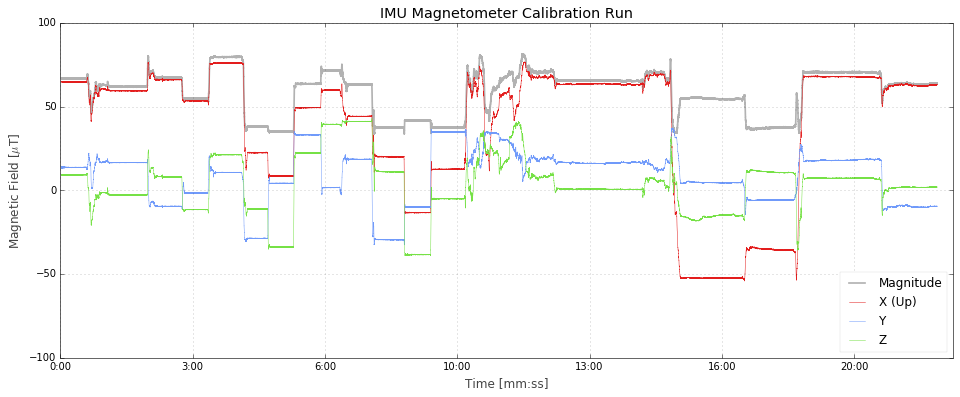

In [2]:
fig, ax1 = plt.subplots(figsize=(16,6))
plt.title(r"IMU Magnetometer Calibration Run")
plt.ylabel(r"Magnetic Field [$ \mu$T]")
plt.xlabel(r"Time [mm:ss]")

plt.plot(cal_time, mag, 'k-', alpha=0.3, label="Magnitude")
plt.plot(cal_time, mag_x, lw=0.5, label="X (Up)")
plt.plot(cal_time, mag_y, lw=0.5, label="Y")
plt.plot(cal_time, mag_z, lw=0.5, label="Z")

plt.xlim([0,1350])
plt.ylim([-100,100])
ax1.xaxis.set_major_formatter(FuncFormatter(minsec))
ax1.legend(loc=4)
plt.show()

It does change, because we have a big offset in some direction. The other way to look at this is a 3D plot of all the values. They _should_ land on a sphere, but instead it's an elongated ellipsoid.

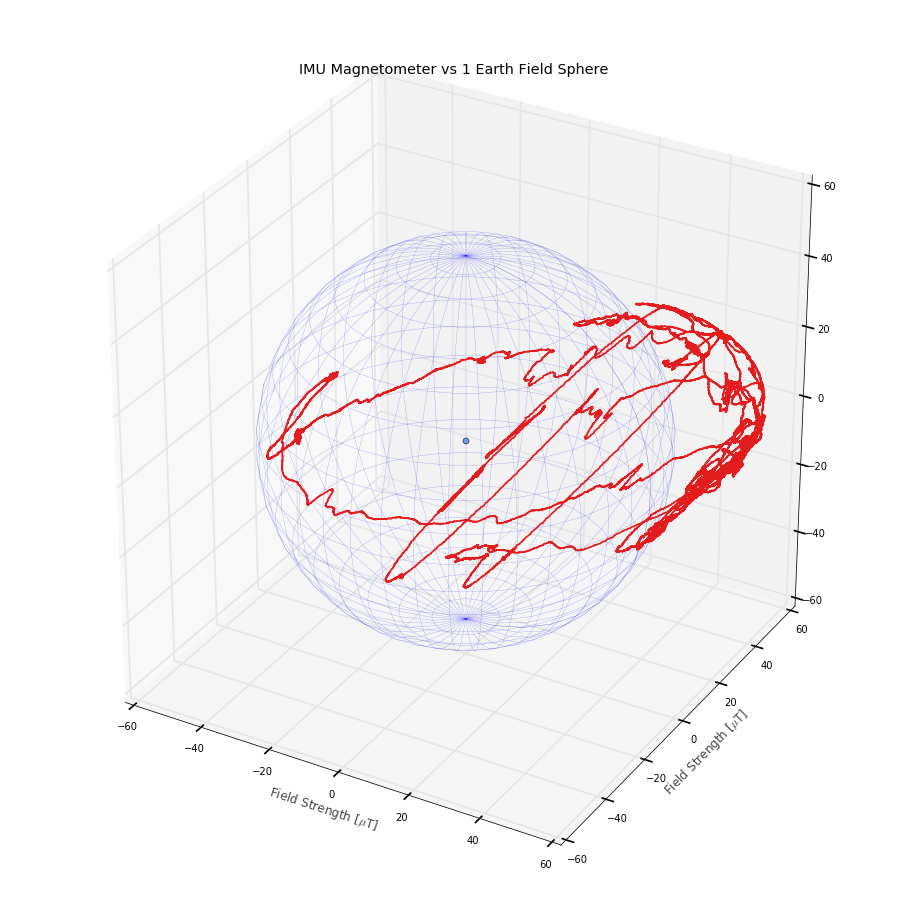

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from numpy import mgrid, pi, sin, cos
fig, ax1 = plt.subplots(figsize=(16,16))
ax1 = plt.axes(projection='3d')
plt.title(r"IMU Magnetometer vs 1 Earth Field Sphere")
plt.xlabel(r"Field Strength [$\mu$T]")
plt.ylabel(r"Field Strength [$\mu$T]")

u, v = mgrid[0:2*pi:40j, 0:pi:20j]
radius = 52.129
x=cos(u)*sin(v)*radius
y=sin(u)*sin(v)*radius
z=cos(v)*radius
ax1.plot_wireframe(x, y, z, color="b", alpha=0.4, lw=0.3)


ax1.plot(mag_x,mag_y,mag_z, '-')
ax1.plot([0],[0],[0], 'o')


ax1.set_xlim(-60, 60)
ax1.set_ylim(-60, 60)
ax1.set_zlim(-60, 60)

ax1.set_aspect('equal','box')
plt.show()